In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import re
import seaborn as sns


In [2]:
#df = pd.read_csv('../input/train.csv')
#df_test = pd.read_csv('../input/test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("Cols: ", df.columns)

print("Cab", len(df[df['Cabin'].isnull()][['Cabin', 'Name' ]]))
print("Emb", len(df[df['Embarked'].isnull()][['Embarked', 'Name' ]]))
print("Sex", len(df[df['Sex'].isnull()][['Sex', 'Name' ]]))
print("Age", len(df[df['Age'].isnull()][['Age', 'Name' ]]))
print("Par", len(df[df['Parch'].isnull()][['Parch', 'Name' ]]))
print("Sib", len(df[df['SibSp'].isnull()][['SibSp', 'Name' ]]))
print("Far", len(df[df['Fare'].isnull()][['Fare', 'Name' ]]))
print("Tic", len(df[df['Ticket'].isnull()][['Ticket', 'Name' ]]))
print("Pcl", len(df[df['Pclass'].isnull()][['Pclass', 'Name' ]]))

# Filling NAs
df["Embarked"] = df["Embarked"].fillna('C')

# Fill missing fields with columns means
df = df.fillna(df.mean())
df['Cabin'] = df['Cabin'].fillna('U')

# Fill missing fields with columns means
df_test = df_test.fillna(df_test.mean())
df_test['Cabin'] = df_test['Cabin'].fillna('U')


# Extracting numeric part from tickets and creating a new feature
ticketnos = []
for s in df['Ticket']:
    ticketnos.append(''.join([n for n in s.split() if n.isdigit()]))
df['TicketNo'] = pd.to_numeric(pd.Series(ticketnos))
df['TicketNo'] = df['TicketNo'].fillna(df['TicketNo'].median())

ticketnos = []
for s in df_test['Ticket']:
    ticketnos.append(''.join([n for n in s.split() if n.isdigit()]))
df_test['TicketNo'] = pd.to_numeric(pd.Series(ticketnos))


print(df.describe())
print(df.dtypes)

# Transforming cabin code to a deck, adding 'U' (unknown) for the missing ones
df['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df['Cabin']])
df_test['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df_test['Cabin']])



Cols:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Cab 687
Emb 2
Sex 0
Age 177
Par 0
Sib 0
Far 0
Tic 0
Pcl 0
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   13.002015    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   29.699118    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare      TicketNo  
count  891.000000  891.000000  8.910000e+02  
mean     0.381594   32.204208  2.974932e+05  
std      0.80

## Adding new features

Here I try to add some more features in order to take the most from this small dataset

[(18, 23], (23, 55], (0, 18], (55, 80]]
Categories (4, object): [(0, 18] < (18, 23] < (23, 55] < (55, 80]]
[(-1, 2], (2, 5], (5, 7], (7, 11]]
Categories (4, object): [(-1, 2] < (2, 5] < (5, 7] < (7, 11]]
[(20, 40], (40, 57], (0, 20], (57, 85]]
Categories (4, object): [(0, 20] < (20, 40] < (40, 57] < (57, 85]]


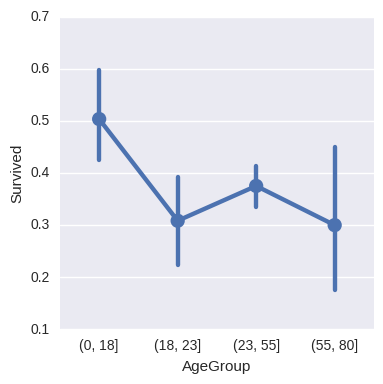

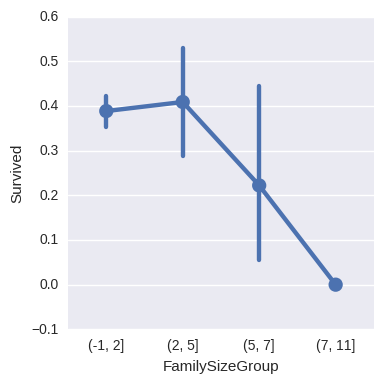

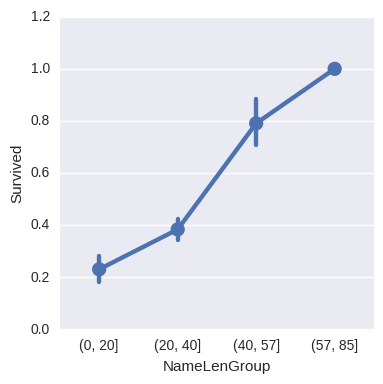

In [8]:
#--------------------
# Under-18 feature
df['U18'] = df['Age'] < 18
df_test['U18'] = df_test['Age'] < 18

bins = [0, 18, 23, 55, 80]
df['AgeGroup'] = pd.cut(df['Age'], bins)
df_test['AgeGroup'] = pd.cut(df_test['Age'], bins)

sns.factorplot(x="AgeGroup", y="Survived", data=df)
print(df["AgeGroup"].unique())

#--------------------
# Family size
df['FamilySize'] = (df['Parch'] + df['SibSp'])
df_test['FamilySize'] = (df_test['Parch'] + df_test['SibSp'])

bins = [-1, 2, 5, 7, 11]
df['FamilySizeGroup'] = pd.cut(df['FamilySize'], bins)
df_test['FamilySizeGroup'] = pd.cut(df_test['FamilySize'], bins)

sns.factorplot(x="FamilySizeGroup", y="Survived", data=df)
print(df["FamilySizeGroup"].unique())

#--------------------
# Name length
df['NameLen'] = [len(n) for n in df['Name']]
df_test['NameLen'] = [len(n) for n in df_test['Name']]

bins = [0, 20, 40, 57, 85]
df['NameLenGroup'] = pd.cut(df['NameLen'], bins)
df_test['NameLenGroup'] = pd.cut(df_test['NameLen'], bins)

sns.factorplot(x="NameLenGroup", y="Survived", data=df)
print(df["NameLenGroup"].unique())
#--------------------



# Labeling

In [9]:

labels = ['Sex', 'Embarked', 'Deck', 'NameLenGroup', 'FamilySizeGroup', 'AgeGroup']
les = {}

for l in labels:
    print('labeling ' + l)
    les[l] = LabelEncoder()
    print(df[l])
    les[l].fit(df[l])
    tr = les[l].transform(df[l]) 
    df.loc[:, l + '_feat'] = pd.Series(tr, index=df.index)

    tr_test = les[l].transform(df_test[l]) 
    df_test.loc[:, l + '_feat'] = pd.Series(tr_test, index=df_test.index)


# le.classes_
#print(df.head())

labeling Sex
0        male
1      female
2      female
3      female
4        male
5        male
6        male
7        male
8      female
9      female
10     female
11     female
12       male
13       male
14     female
15     female
16       male
17       male
18     female
19     female
20       male
21       male
22     female
23       male
24     female
25     female
26       male
27       male
28     female
29       male
        ...  
861      male
862    female
863    female
864      male
865    female
866    female
867      male
868      male
869      male
870      male
871    female
872      male
873      male
874    female
875    female
876      male
877      male
878      male
879    female
880    female
881      male
882    female
883      male
884      male
885    female
886      male
887    female
888    female
889      male
890      male
Name: Sex, dtype: object
labeling Embarked
0      S
1      C
2      S
3      S
4      S
5      Q
6      S
7      S
8      S
9      C


## Preparing datasets

In [13]:
X_train = df.drop(labels, 1) \
    .drop('Survived', 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('NameLen', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)
y_train = df['Survived']

X_test = df_test.drop(labels, 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('NameLen', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)

print("X_train shape", X_train.shape)
print("X_test  shape", X_test.shape)

#X_train.describe()
#X_test.describe()


X_train shape (891, 14)
X_test  shape (418, 14)


## Some visualizations

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


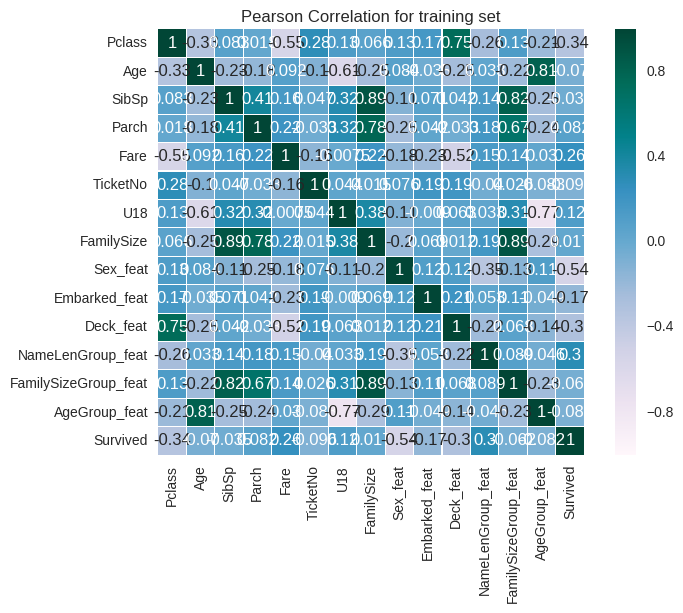

In [14]:

full_set = X_train[:]
full_set['Survived'] = y_train

plt.title('Pearson Correlation for training set')
sns.heatmap(full_set.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap="PuBuGn", 
            linecolor='w', 
            annot=True)


TODO: I'll try to remove Age, SibSp and Parch from the training set because they seem to be very less related to the Survival than the other features

In [15]:
X_train = X_train.drop('Age', 1) \
    .drop('SibSp', 1) \
    .drop('Parch', 1) 

X_test = X_test.drop('Age', 1) \
    .drop('SibSp', 1) \
    .drop('Parch', 1) 


# Training some models

I split the set in a training set and a validation set in order to check the algorithm score once trained

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import math

X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print(X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape)


(596, 11) (596,) (295, 11) (295,)


#### Decision tree

In [17]:
tree = DecisionTreeClassifier()
tree.fit(X_tr, y_tr)

pred = tree.predict(X_ts)

err = math.sqrt(((pred - y_ts)**2).mean())
print("Error: %.3f" % err)


Error: 0.473


The decision tree seems to overfit the dataset

In [18]:
# Training the validated model with the whole training set
tree.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = tree.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_tree.csv', index=False)


(596, 11)
(418, 11)


#### Logistic regression

In [19]:
C = 0.01
logistic = LogisticRegression(C = C)
logistic.fit(X_tr, y_tr)
pred = logistic.predict(X_ts)

score = logistic.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))


Error: 0.546 Score: 0.702


In [20]:
# Training the validated model with the whole training set
logistic.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = logistic.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_logistic.csv', index=False)


(596, 11)
(418, 11)


#### SVC with linear kernel

In [21]:
from sklearn import svm

C = 1.0
svc = svm.SVC(kernel='linear', C=C)
svc.fit(X_tr, y_tr)

pred = svc.predict(X_ts)

score = svc.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))

Error: 0.624 Score: 0.610


In [22]:
# Training the validated model with the whole training set
svc.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = svc.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_svc.csv', index=False)


(596, 11)
(418, 11)


#### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=50)
forest.fit(X_tr, y_tr)

pred = forest.predict(X_ts)

score = forest.score(X_ts, y_ts)
err = math.sqrt(((pred - y_ts)**2).mean())

print("Error: %.3f Score: %.3f" % (err, score))

Error: 0.443 Score: 0.803


In [24]:
# Training the validated model with the whole training set
forest.fit(X_train, y_train)

print(X_tr.shape)
print(X_test.shape)
pred = forest.predict(X_test)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]

sub.to_csv('submission_forest.csv', index=False)


(596, 11)
(418, 11)
